In [28]:
from pandas import read_csv, DatetimeIndex
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
import numpy 
import matplotlib.pyplot as plt 

In [24]:
raw_data = read_csv("1998 to 2023 CombinedData.csv")
raw_data.columns

Index(['Unnamed: 0', 'name', 'datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions',
       'description', 'icon', 'stations'],
      dtype='object')

Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       ...
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
      dtype='int32', name='datetime', length=9496)

In [44]:
df = raw_data[["datetime", "temp"]]
df["month"] = DatetimeIndex(raw_data["datetime"]).month
df["year"] = DatetimeIndex(raw_data["datetime"]).year 
df["month_year"] = df["year"] * 10000 + df["month"]

C:\Users\Alaric\AppData\Local\Temp\ipykernel_14308\3416679612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = DatetimeIndex(raw_data["datetime"]).month
C:\Users\Alaric\AppData\Local\Temp\ipykernel_14308\3416679612.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = DatetimeIndex(raw_data["datetime"]).year
C:\Users\Alaric\AppData\Local\Temp\ipykernel_14308\3416679612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

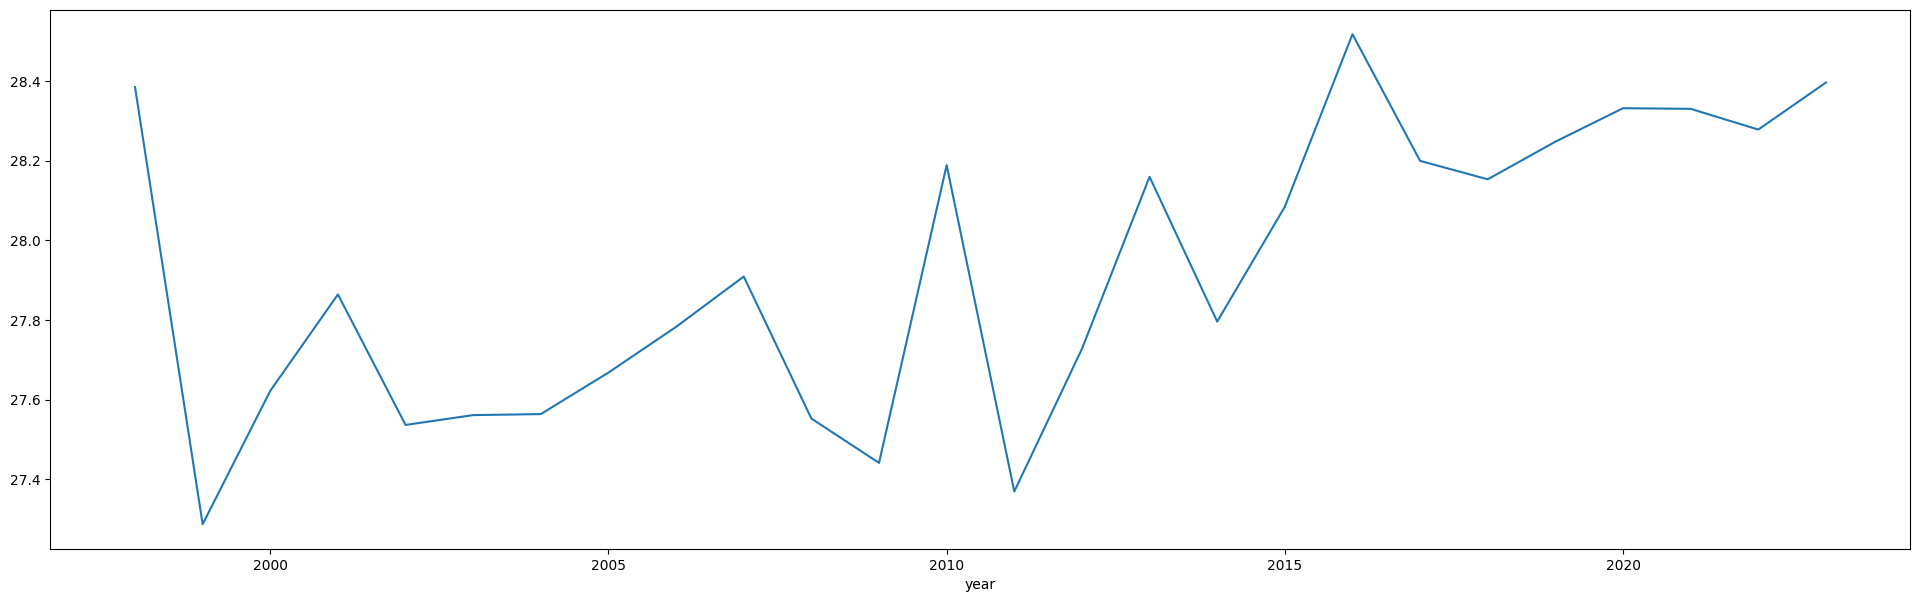

In [45]:
yearly_means = df.groupby(by = "year").mean(numeric_only = True)["temp"]
yearly_means.plot(figsize = (24, 7))
plt.show()

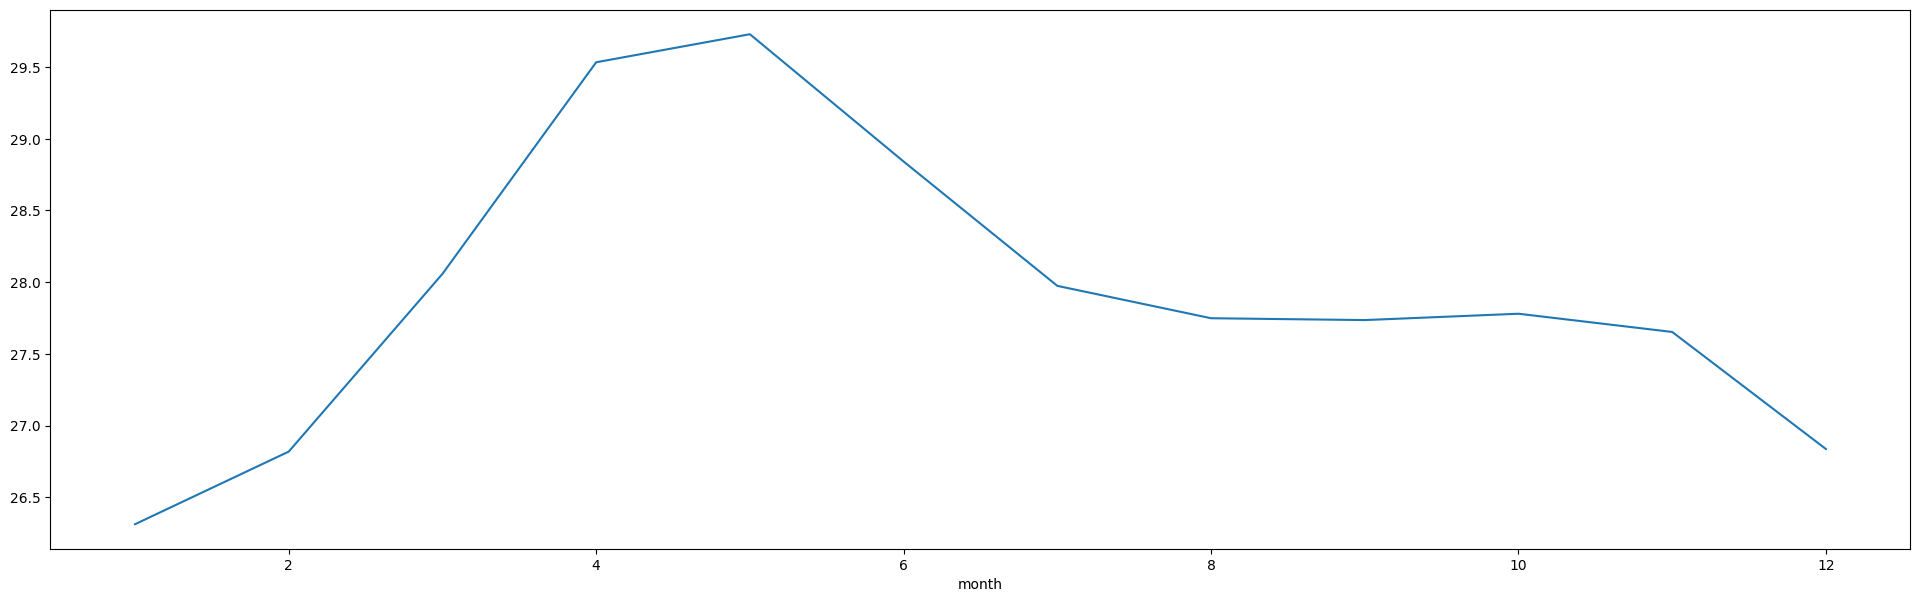

In [46]:
monthly_means = df.groupby(by = "month").mean(numeric_only = True)["temp"]
monthly_means.plot(figsize = (24, 7))
plt.show()

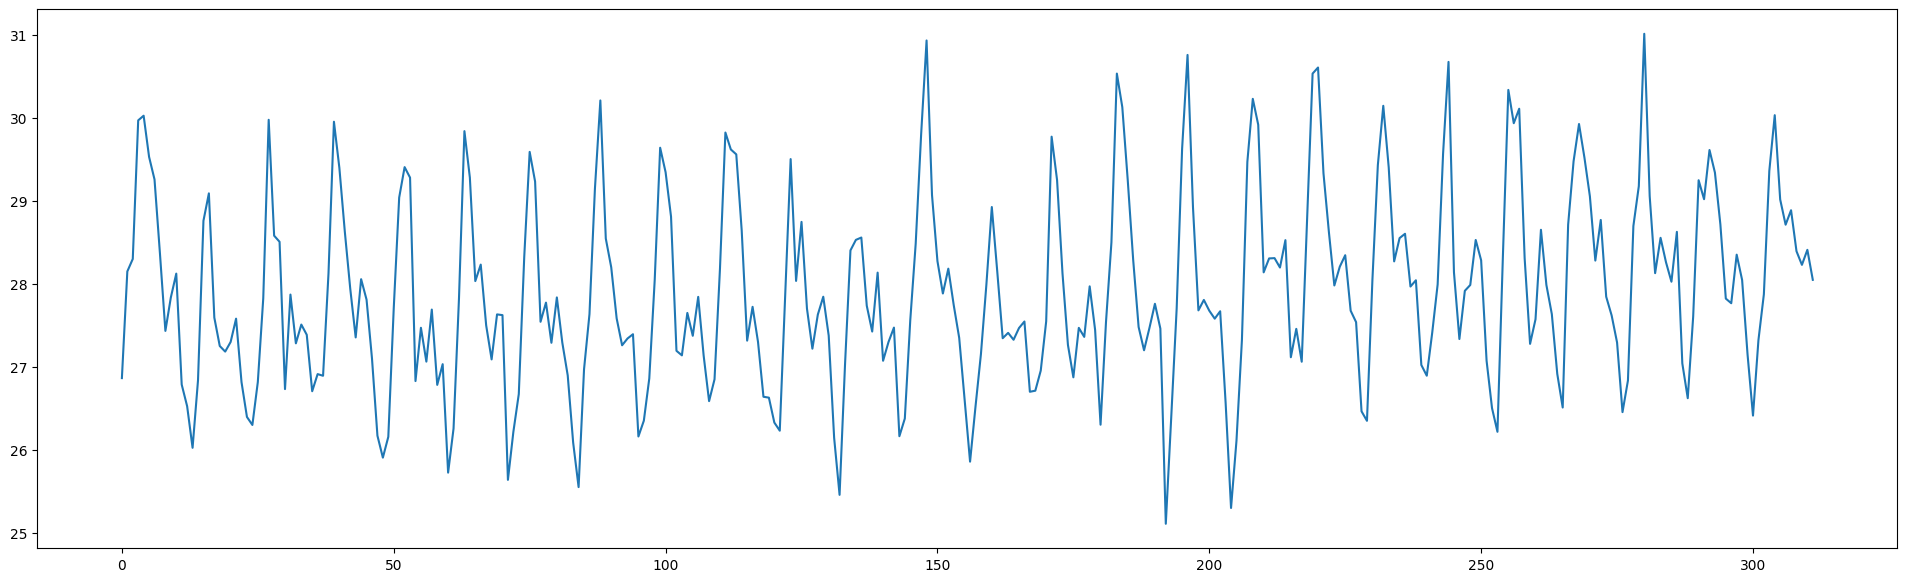

In [84]:
month_year_means = df.groupby(by = "month_year").mean(numeric_only = True)["temp"]
plt.figure(figsize=(24, 7))
plt.plot(month_year_means.to_numpy())
plt.show()

In [103]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [104]:
series = month_year_means.copy()
# series_mean = series.mean()
# series -= series_mean

In [105]:
split_point = int(len(series) * 7 / 10)
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 218, Validation 94


In [112]:
# seasonal difference
X = dataset.values
diff_len = 12
differenced = difference(X, diff_len)
# fit model
# model = ARIMA(X, order=(7,0,1))
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  206
Model:                 ARIMA(7, 0, 1)   Log Likelihood                -201.796
Date:                Sat, 08 Jun 2024   AIC                            423.591
Time:                        15:55:54   BIC                            456.870
Sample:                             0   HQIC                           437.050
                                - 206                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0153      0.016      0.930      0.352      -0.017       0.048
ar.L1          1.1685      0.079     14.816      0.000       1.014       1.323
ar.L2         -0.0383      0.116     -0.329      0.7

In [115]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=7000)
# invert the differenced forecast to something usable
history = [x for x in X]
original_history = history.copy()

day = 1
for yhat in forecast:
	# inverted = series_mean + yhat
	inverted = inverse_difference(history, yhat, diff_len)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 27.848748
Day 2: 29.788076
Day 3: 30.238323
Day 4: 29.787138
Day 5: 27.849145
Day 6: 27.749805
Day 7: 27.598179
Day 8: 27.369836
Day 9: 27.628902
Day 10: 26.202942
Day 11: 26.558748
Day 12: 26.210887
Day 13: 27.084137
Day 14: 29.136778
Day 15: 29.722220
Day 16: 29.420207
Day 17: 27.636762
Day 18: 27.691528
Day 19: 27.687142
Day 20: 27.593086
Day 21: 27.968754
Day 22: 26.637761
Day 23: 27.064257
Day 24: 26.761489
Day 25: 27.653994
Day 26: 29.700936
Day 27: 30.257631
Day 28: 29.906566
Day 29: 28.057209
Day 30: 28.033139
Day 31: 27.941218
Day 32: 27.755239
Day 33: 28.038814
Day 34: 26.619498
Day 35: 26.964965
Day 36: 26.591436
Day 37: 27.425787
Day 38: 29.428831
Day 39: 29.956809
Day 40: 29.592429
Day 41: 27.744704
Day 42: 27.736154
Day 43: 27.672054
Day 44: 27.524196
Day 45: 27.853879
Day 46: 26.486160
Day 47: 26.886145
Day 48: 26.567536
Day 49: 27.454836
Day 50: 29.506728
Day 51: 30.077640
Day 52: 29.748840
Day 53: 27.928309
Day 54: 27.937962
Day 55: 27.882894
Day 56: 27.735120
D

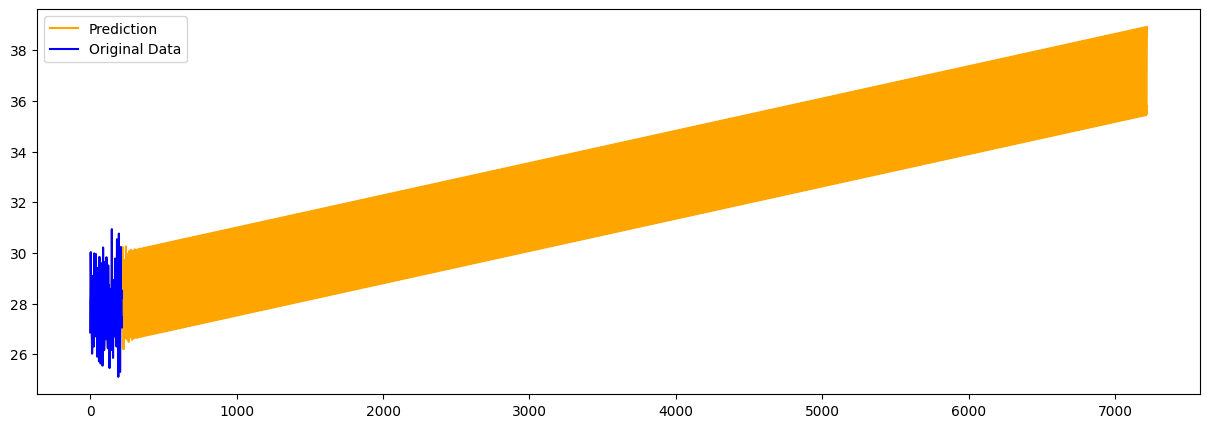

In [114]:
plt.figure(figsize=(15, 5))
plt.plot(numpy.array(history).flatten(), alpha = 1.0, label = "Prediction", color = "orange")
plt.plot(original_history, alpha = 1.0, label = "Original Data", color = "blue")
plt.legend()
plt.show()